## Project Beer reviews 
### Group SustainablePandas
Groups members: Bastien Amez-Droz, Noé Fellay, Nicolas Frédéric Rochat, Baptiste Michel \
TA: Halima Schede

### Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import gzip
import shutil

import seaborn as sns
import math
import matplotlib
import pandas as pd
import os
import numpy as np


### Uncompress folders and files

In [2]:
def ungzip_folder(FOLDER_NAME):
    """
    This function allows to extract datas from gzip folder into a new accessible folder
    - FOLDER_NAME: name of the folder to create from the gzip folder
    The function returns nothing, it only creates the new folder
    """
    FOLDER_PATH = './Data/' + FOLDER_NAME
    
    #check if folder is already unzipped
    if os.path.exists(FOLDER_PATH) == False:
    
        # open folder
        folder = tarfile.open(FOLDER_PATH + '.tar.gz',"r:gz")
        # extracting folder
        folder.extractall(FOLDER_PATH)
        # closing folder
        folder.close()

In [3]:
ungzip_folder("RateBeer")

In [4]:
def ungzip_txt_file(FOLDER_NAME, FILE_NAME):
    """
    This function allows to extract datas from gzip file into a new accessible file
    - FOLDER_NAME: name of the folder in which the gzip file is
    - FILE_NAME: name of the file to create from the gzip file
    The function returns nothing, it only creates the new file
    """
    FILE_PATH = './Data/' + FOLDER_NAME + '/' + FILE_NAME
    
    #check if file is already unzipped
    if os.path.exists(FILE_PATH) == False:
    
        with gzip.open(FILE_PATH + '.gz', 'r') as f_in:
            with open(FILE_PATH, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [5]:
ungzip_txt_file("RateBeer","ratings.txt")
ungzip_txt_file("RateBeer","reviews.txt")

### Extract infos from txt files

In [6]:
def txt_to_dataframe(FOLDER_NAME,TXT_FILE_NAME,keys_list):
    """
    This function allows to pass the txt file to a dataframe
    - FOLDER_NAME: name of the folder in which the txt file is
    - TXT_FILE_NAME: text file with a dictionary format
    - keys_list: list of keys for the columns
    The function returns a dataframe file
    """
    dict_list = []
    newDict = {key: None for key in keys_list}
    
    FILE_PATH = './Data/' + FOLDER_NAME + '/' + TXT_FILE_NAME

    with open(FILE_PATH, 'r', encoding="utf8") as f:
    
        for line in f:
            line = line.replace(u'\xa0','')
            listedline = line.split(':',1) # split around the ":" sign
        
            # take non-empty lines
            if len(listedline) > 1:
                newDict[listedline[0]] = listedline[1].strip()
        
            # finish the dictionary for the line
            if listedline[0] == keys_list[-1]:
                dict_list.append(newDict)
            
                # reinitialize the dictionary for the next line
                newDict = {key: None for key in keys_list}
    
        # transform list of dictionaries to dataframe
        df = pd.DataFrame(dict_list,columns=keys_list)    
    
    return df

In [7]:
keys_reviews = (['beer_name','beer_id','brewery_name','brewery_id','style','abv','date','user_name','user_id',\
                          'appearance','aroma','palate','taste','overall','rating','text'])

df_reviews_RB = txt_to_dataframe("RateBeer","reviews.txt",keys_reviews)

In [9]:
df_reviews_RB.head()

7122074

### Extract infos from csv files

In [10]:
df_beers_RB = pd.read_csv("./Data/RateBeer/beers.csv")
df_users_RB = pd.read_csv("./Data/RateBeer/users.csv")
df_breweries_RB = pd.read_csv("./Data/RateBeer/breweries.csv")

df_breweries_RB.rename(columns={"id": "brewery_id"}, inplace=True)

In [11]:
df_breweries_RB.head()

,brewery_id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


### Create a dataframe for further analyses

Dataframe format: &emsp; beer_name | beer_id | brewery_id | date | rating | user_location | brewery_location

In [12]:
df_reviews_RB['user_id'] = df_reviews_RB['user_id'].astype(int)
df_reviews_RB['brewery_id'] = df_reviews_RB['brewery_id'].astype(int)
df_reviews_RB['rating'] = df_reviews_RB['rating'].astype(float)

# merge reviews and users on user id
df_reviews_users_RB=pd.merge(df_reviews_RB, df_users_RB, how="left", on=['user_id']) #'user_name',
# merge reviews and users on brewery id
df_all_RB = pd.merge(df_reviews_users_RB,df_breweries_RB, how='left', on=['brewery_id'])

# rename some variables
df_all_RB.rename(columns={"location_x": "user_location"}, inplace=True)
df_all_RB.rename(columns={"location_y": "brewery_location"}, inplace=True)
df_all_RB.rename(columns={"user_name_x": "user_name"}, inplace=True)

# remove doubles
df_all_RB = df_all_RB.drop(["user_name_y","name"], axis=1)

# set time variable
df_all_RB['date'] = pd.to_datetime(df_all_RB['date'], unit='s')
df_all_RB['joined'] = pd.to_datetime(df_all_RB['joined'], unit='s')


df_all_RB.head(1)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,palate,taste,overall,rating,text,nbr_ratings,joined,user_location,brewery_location,nbr_beers
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,...,2,4,8,2.0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",1890.0,2012-05-20 10:00:00,Poland,Gabon,3


In [20]:
# keep only keys of interest
keys_to_drop = ['brewery_name', 'abv', 'user_name', 'appearance', 'user_id', 'aroma', 'palate', 'taste', 'overall', 'text', 'nbr_ratings', 'joined', 'nbr_beers']
df_interest_RB= df_all_RB.drop(keys_to_drop, axis=1)
df_interest_RB.head(1)

,beer_name,beer_id,brewery_id,style,date,rating,user_location,brewery_location
0,33 Export (Gabon),410549,3198,Pale Lager,2016-04-26 10:00:00,2.0,Poland,Gabon


### Histogram of reviews over time

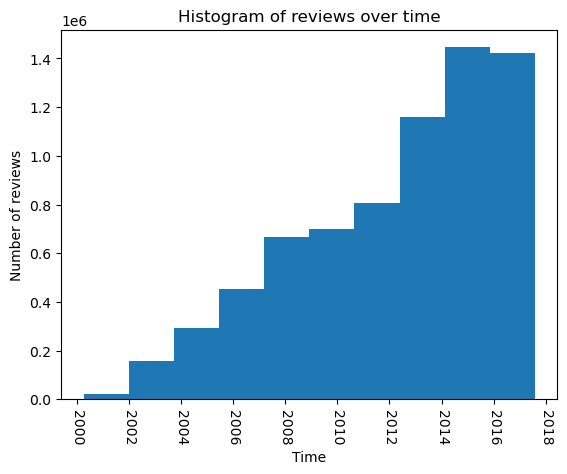

In [14]:
# Histogram of reviews over time
plt.hist(df_interest_RB['date'])

plt.title("Histogram of reviews over time")
plt.xlabel("Time")
plt.xticks(rotation=270)
plt.ylabel("Number of reviews")
plt.show()

### Reviews per US State and country

In [16]:
# split user location into country and county
df_interest_RB[["user_country","user_county"]] = df_interest_RB['user_location'].str.split(pat = ', ', expand = True)
df_interest_RB.fillna("",inplace=True)

# create a dataframe on counties from United States
Num_county = df_interest_RB.groupby(["user_country","user_county"])["user_county"].count()
Num_county = Num_county["United States"]
df_county = Num_county.to_frame()
df_county.rename(columns = {'user_county':'reviews'}, inplace = True)

# create a dataframe on countries
Num_country = df_interest_RB.groupby(["user_country"])["user_country"].count()
df_country = Num_country.to_frame()
df_country.rename(columns = {'user_country':'reviews'}, inplace = True)

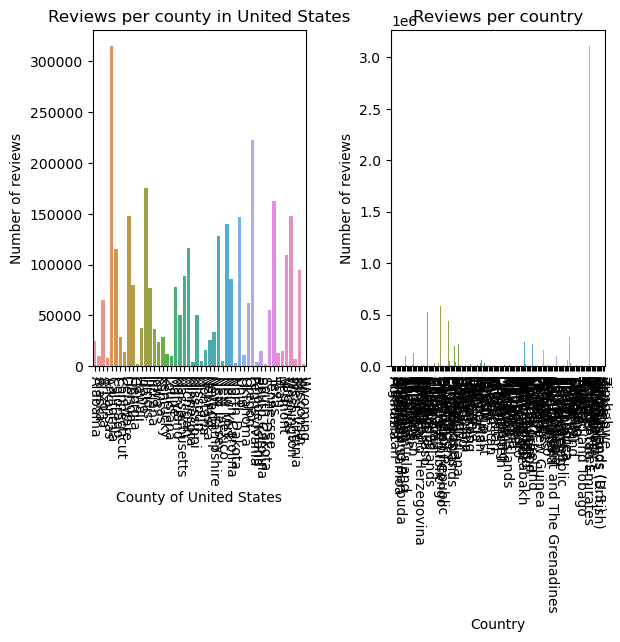

In [17]:
# Plot of reviews per county in US
plt.subplot(121)
sns.barplot(x = df_county.index, y="reviews",data=df_county)

plt.title("Reviews per county in United States")
plt.xlabel("County of United States")
plt.xticks(rotation=270)
plt.ylabel("Number of reviews")

# Plot of reviews per country
plt.subplot(122)
sns.barplot(x = df_country.index, y="reviews",data=df_country)

plt.title("Reviews per country")
plt.xlabel("Country")
plt.xticks(rotation=270)
plt.ylabel("Number of reviews")

plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

### Breweries per location

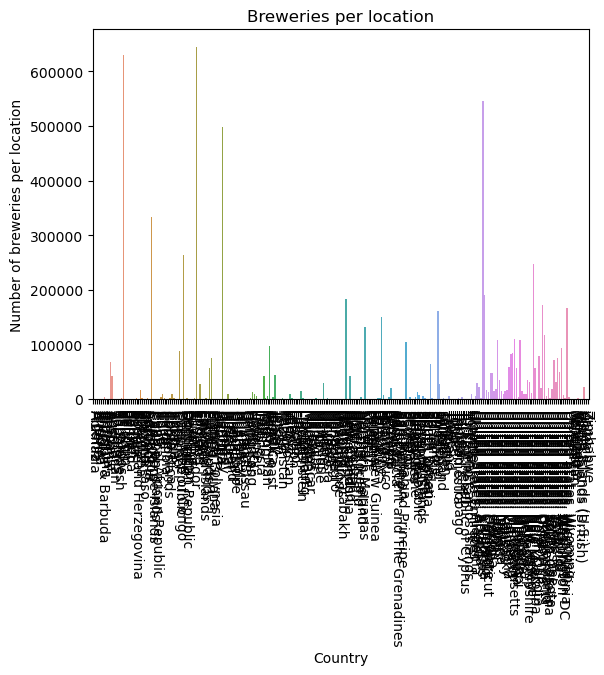

In [110]:
Num_brewery = df_interest_RB.groupby('brewery_location')['brewery_location'].count()
df_brewery = Num_brewery.to_frame()
df_brewery.rename(columns = {'brewery_location':'breweries'}, inplace = True)

# Plot of breweries per location
sns.barplot(x = Num_brewery.index, y="breweries",data=df_brewery)

plt.title("Breweries per location")
plt.xlabel("Country")
plt.xticks(rotation=270)
plt.ylabel("Number of breweries per location")
plt.show()

In [125]:
Num_brewery.index

Index(['Abkhazia', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua & Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia',
       ...
       'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela', 'Vietnam',
       'Virgin Islands (British)', 'Virgin Islands (U.S.)', 'Wales', 'Zambia',
       'Zimbabwe'],
      dtype='object', name='brewery_location', length=265)

In [71]:
df_interest_RB_by_brewery_id = df_interest_RB.groupby(["brewery_id","beer_id"])['rating'].agg(['mean','size'])
df_interest_RB_by_brewery_id.head()

mean  size
brewery_id beer_id                
1          10731    2.975455   110
           114065   3.000000     1
           114981   3.280000     5
           117017   3.700000     1
           117066   3.583333    12

### Regroup styles in global categories

In [134]:
categories = (['Lager & Pilsner', 'Dark Lager', 'Bock', 'Brown Ale', \
               'Pale Ale', 'IPA', 'Porter', 'Stout', 'Belgian', 'Wheat', \
               'Sour', 'Strong', 'Scottish', 'Low alcohol', 'Cider', 'Saké', \
               'Mead', 'Radler', 'Aromatised', 'Rauchbier', 'Fruit', 'Hybrid', 'Other'])
cat_names = (['lager','dark_lager','bock','brown','pale','ipa','porter','stout','belgian','wheat','sour','strong','scottish','low','cider','sake',\
              'mead','radler','aromatised','smoked','fruit','hybrid','other'])

# Pale lager and Pilsner
lager = (['Pale Lager', 'Zwickel/Keller/Landbier', 'Saison', 'Pilsener',  'Premium Lager', 'Dortmunder/Helles', 'Czech Pilsner (Světlý)', 'Imperial Pils/Strong Pale Lager'])
#Dark lager
dark_lager = (['Dunkel/Tmavý', 'Amber Lager/Vienna', 'Oktoberfest/Märzen', 'Schwarzbier', 'Polotmavý'])
#German Bocks
bock = (['Heller Bock', 'Doppelbock', 'Dunkler Bock', 'Weizen Bock', 'Eisbock'])
#Brown Ales
brown = (['Mild Ale', 'Brown Ale', 'Traditional Ale'])
# Pale Ales
pale = (['Golden Ale/Blond Ale', 'Bitter', 'American Pale Ale', 'Irish Ale',   'Amber Ale', 'Premium Bitter/ESB', 'English Pale Ale', 'Kölsch', 'Altbier'])
#IPA
ipa = (['Black IPA', 'India Pale Ale (IPA)', 'American Strong Ale', 'Session IPA', 'Imperial IPA'])
#Porter
porter = (['Porter',  'Baltic Porter', 'Imperial Porter'])
#Stout
stout = (['Stout', 'Imperial Stout', 'Foreign Stout', 'Dry Stout', 'Sweet Stout'])
#Belgian style
belgian = (['Belgian Ale', 'Abbey Tripel', 'Belgian Strong Ale', 'Bière de Garde', 'Abbey Dubbel', 'Abt/Quadrupel'])
#Wheat beer
wheat = (['Wheat Ale',  'Berliner Weisse', 'German Hefeweizen', 'Witbier', 'Dunkelweizen', 'German Kristallweizen'])
#Wild & Sour Ale
sour = (['Sour/Wild Ale', 'Sour Red/Brown', 'Lambic Style - Fruit', 'Grodziskie/Gose/Lichtenhainer', 'Lambic Style - Gueuze', 'Lambic Style - Unblended', 'Lambic Style - Faro'])
#Strong Ale - belgian strong ale duplicate
strong = (['English Strong Ale', 'American Strong Ale', 'Scotch Ale', 'Barley Wine', 'Old Ale'])
#Scottish ale
scottish = (['Scottish Ale'])
#Low alcohol
low = (['Low Alcohol'])
#Cider
cider = (['Cider', 'Perry'])
#Saké
sake = (['Saké - Daiginjo', 'Saké - Namasaké', 'Saké - Ginjo', 'Saké - Infused', 'Saké - Tokubetsu', 'Saké - Junmai', 'Saké - Nigori', 'Saké - Koshu', 'Saké - Taru', 'Saké - Honjozo', 'Saké - Genshu', 'Saké - Futsu-shu'])
#Mead
mead = (['Mead'])
#Radler
radler = (['Radler/Shandy'])
#Aromatised Spice, herb, vegetable
aromatised = (['Spice/Herb/Vegetable'])
#Rauchbier
smoked = (['Smoked'])
#Fruit beer
fruit = (['Fruit Beer'])
#Hybrid beer (lager yeast but high fermentation)
hybrid = (['India Style Lager', 'California Common', 'Cream Ale'])

#Other
other = (['Sahti/Gotlandsdricke/Koduõlu', 'Specialty Grain', 'Malt Liquor'])


conditions = [
    (df_interest_RB['style'].isin(lager)),
    (df_interest_RB['style'].isin( dark_lager)),
    (df_interest_RB['style'].isin(bock)),
    (df_interest_RB['style'].isin(brown)),
    (df_interest_RB['style'].isin(pale)),
    (df_interest_RB['style'].isin(ipa)),
    (df_interest_RB['style'].isin(porter)),
    (df_interest_RB['style'].isin(belgian)),
    (df_interest_RB['style'].isin(stout)),
    (df_interest_RB['style'].isin(wheat)),
    (df_interest_RB['style'].isin(sour)),
    (df_interest_RB['style'].isin(strong)),
    (df_interest_RB['style'].isin(scottish)),
    (df_interest_RB['style'].isin(low)),
    (df_interest_RB['style'].isin(cider)),
    (df_interest_RB['style'].isin(sake)),
    (df_interest_RB['style'].isin(mead)),
    (df_interest_RB['style'].isin(radler)),
    (df_interest_RB['style'].isin(aromatised)),
    (df_interest_RB['style'].isin(smoked)),
    (df_interest_RB['style'].isin(fruit)),
    (df_interest_RB['style'].isin(hybrid)),
    (df_interest_RB['style'].isin(other))
     ]
     
df_interest_RB['category'] = np.select(conditions, categories)





In [135]:
# Rearrange columns 
new_cols = ['beer_name',
 'beer_id',
 'brewery_id',
 'style',
 'category',
 'date',
 'rating',
 'user_location',
 'brewery_location'
 ]
df_interest_RB=df_interest_RB[new_cols]

In [137]:
#Test if a style of beer doesn't fit in a category
df_interest_RB[df_interest_RB['category']=='0'].head()

,beer_name,beer_id,brewery_id,style,category,date,rating,user_location,brewery_location


### Plot mean rating per category over all reviews

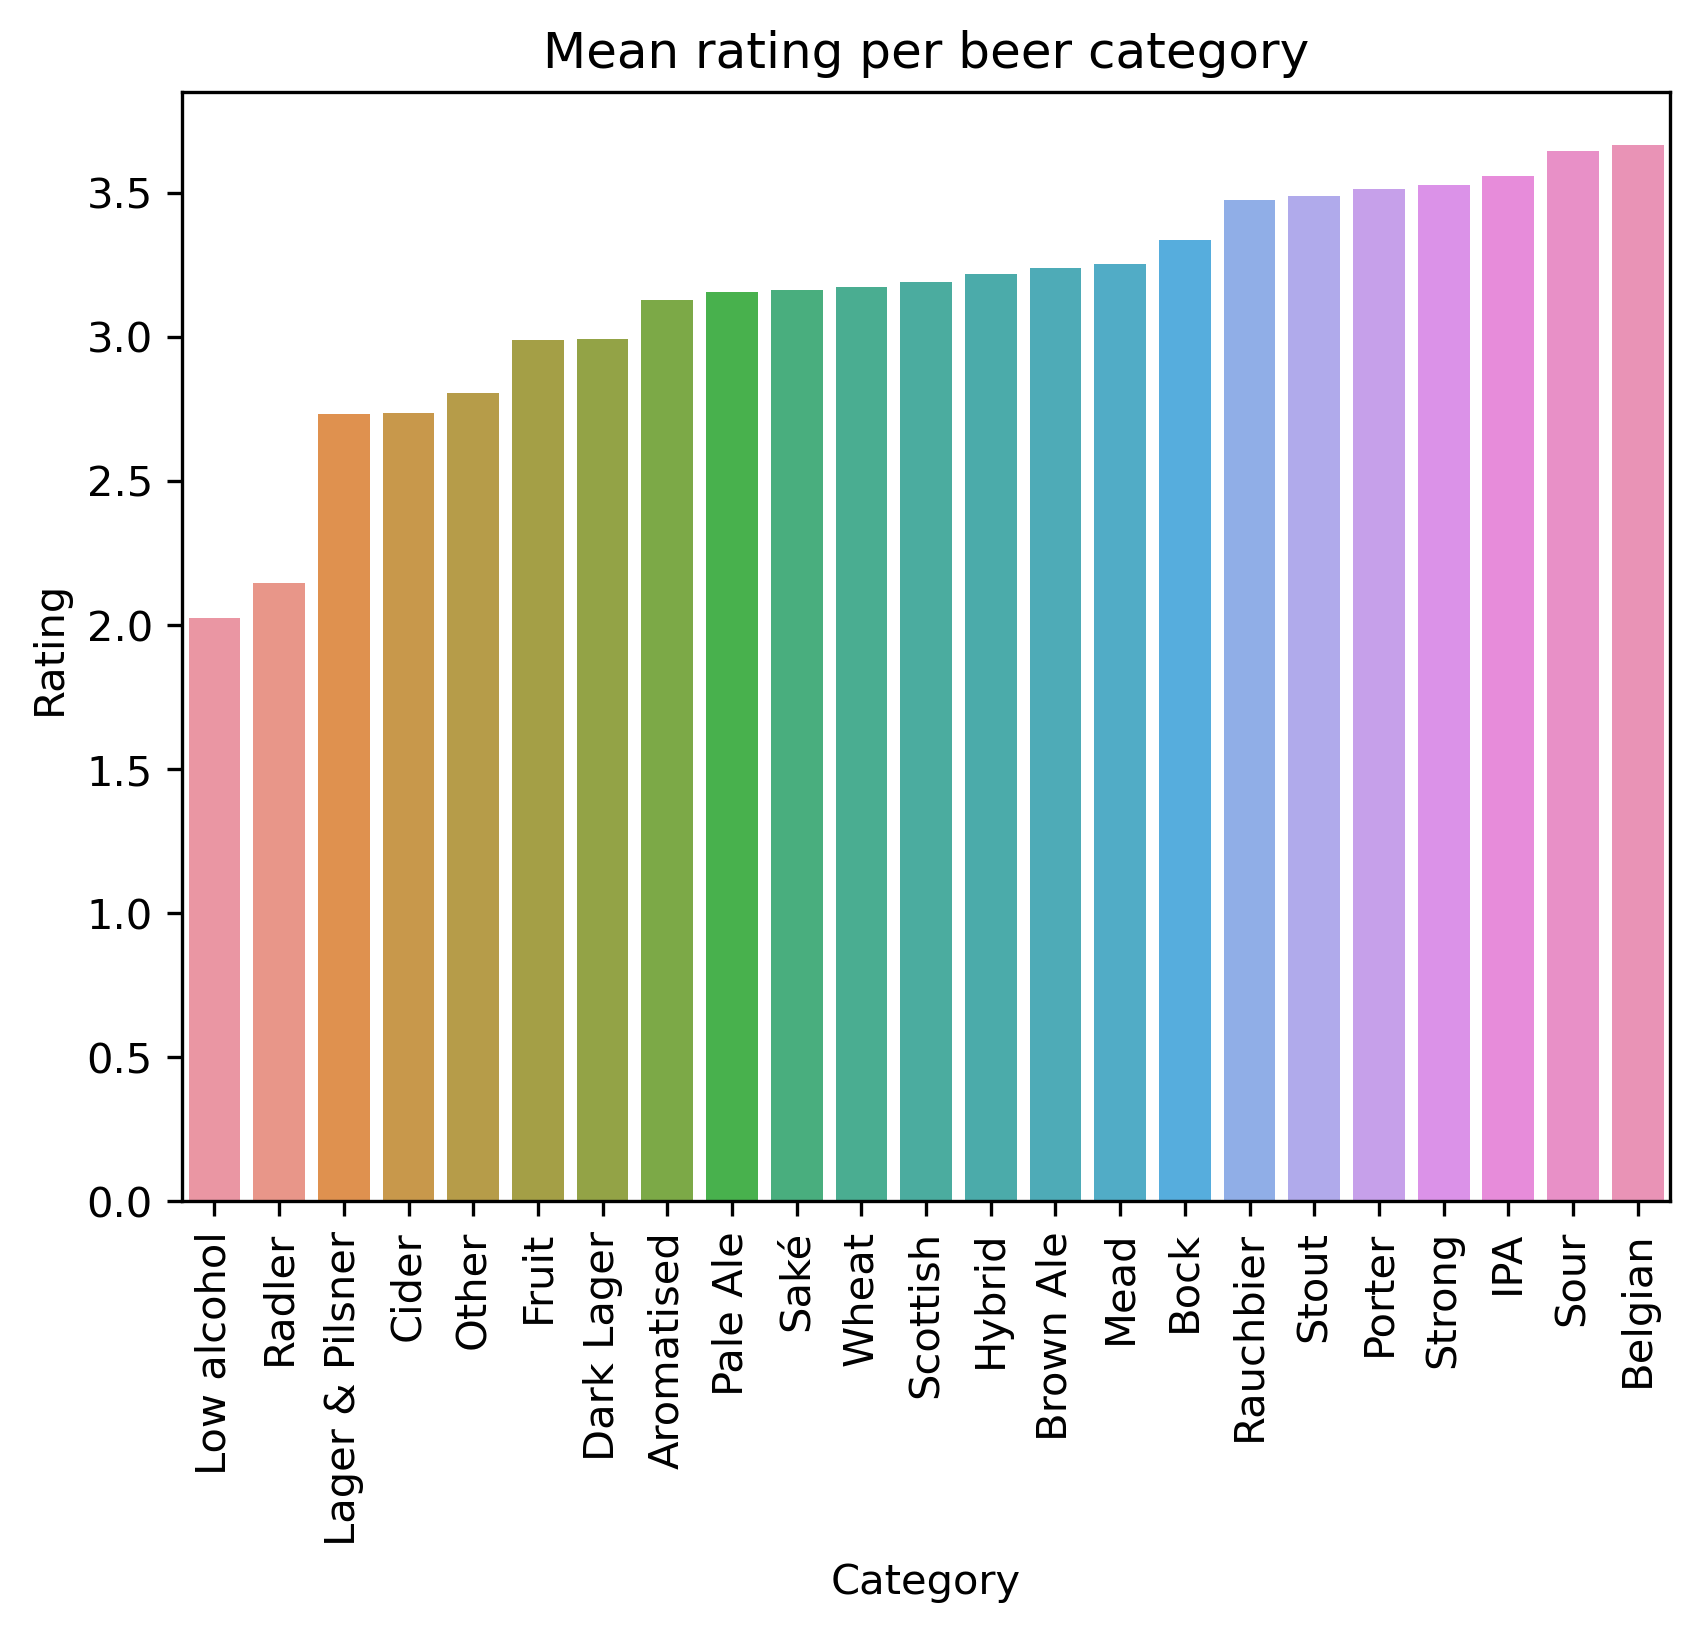

In [173]:
mean_category = df_interest_RB.groupby('category')['rating'].mean()
df_mean_category = mean_category.to_frame()
df_mean_category = df_mean_category.sort_values(by=['rating'])

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['figure.dpi'] = 300

ax = sns.barplot(x = df_mean_category.index,y='rating', data=df_mean_category)
plt.title("Mean rating per beer category")
plt.xlabel("Category")
plt.xticks(rotation=90)
plt.ylabel("Rating")
plt.show()

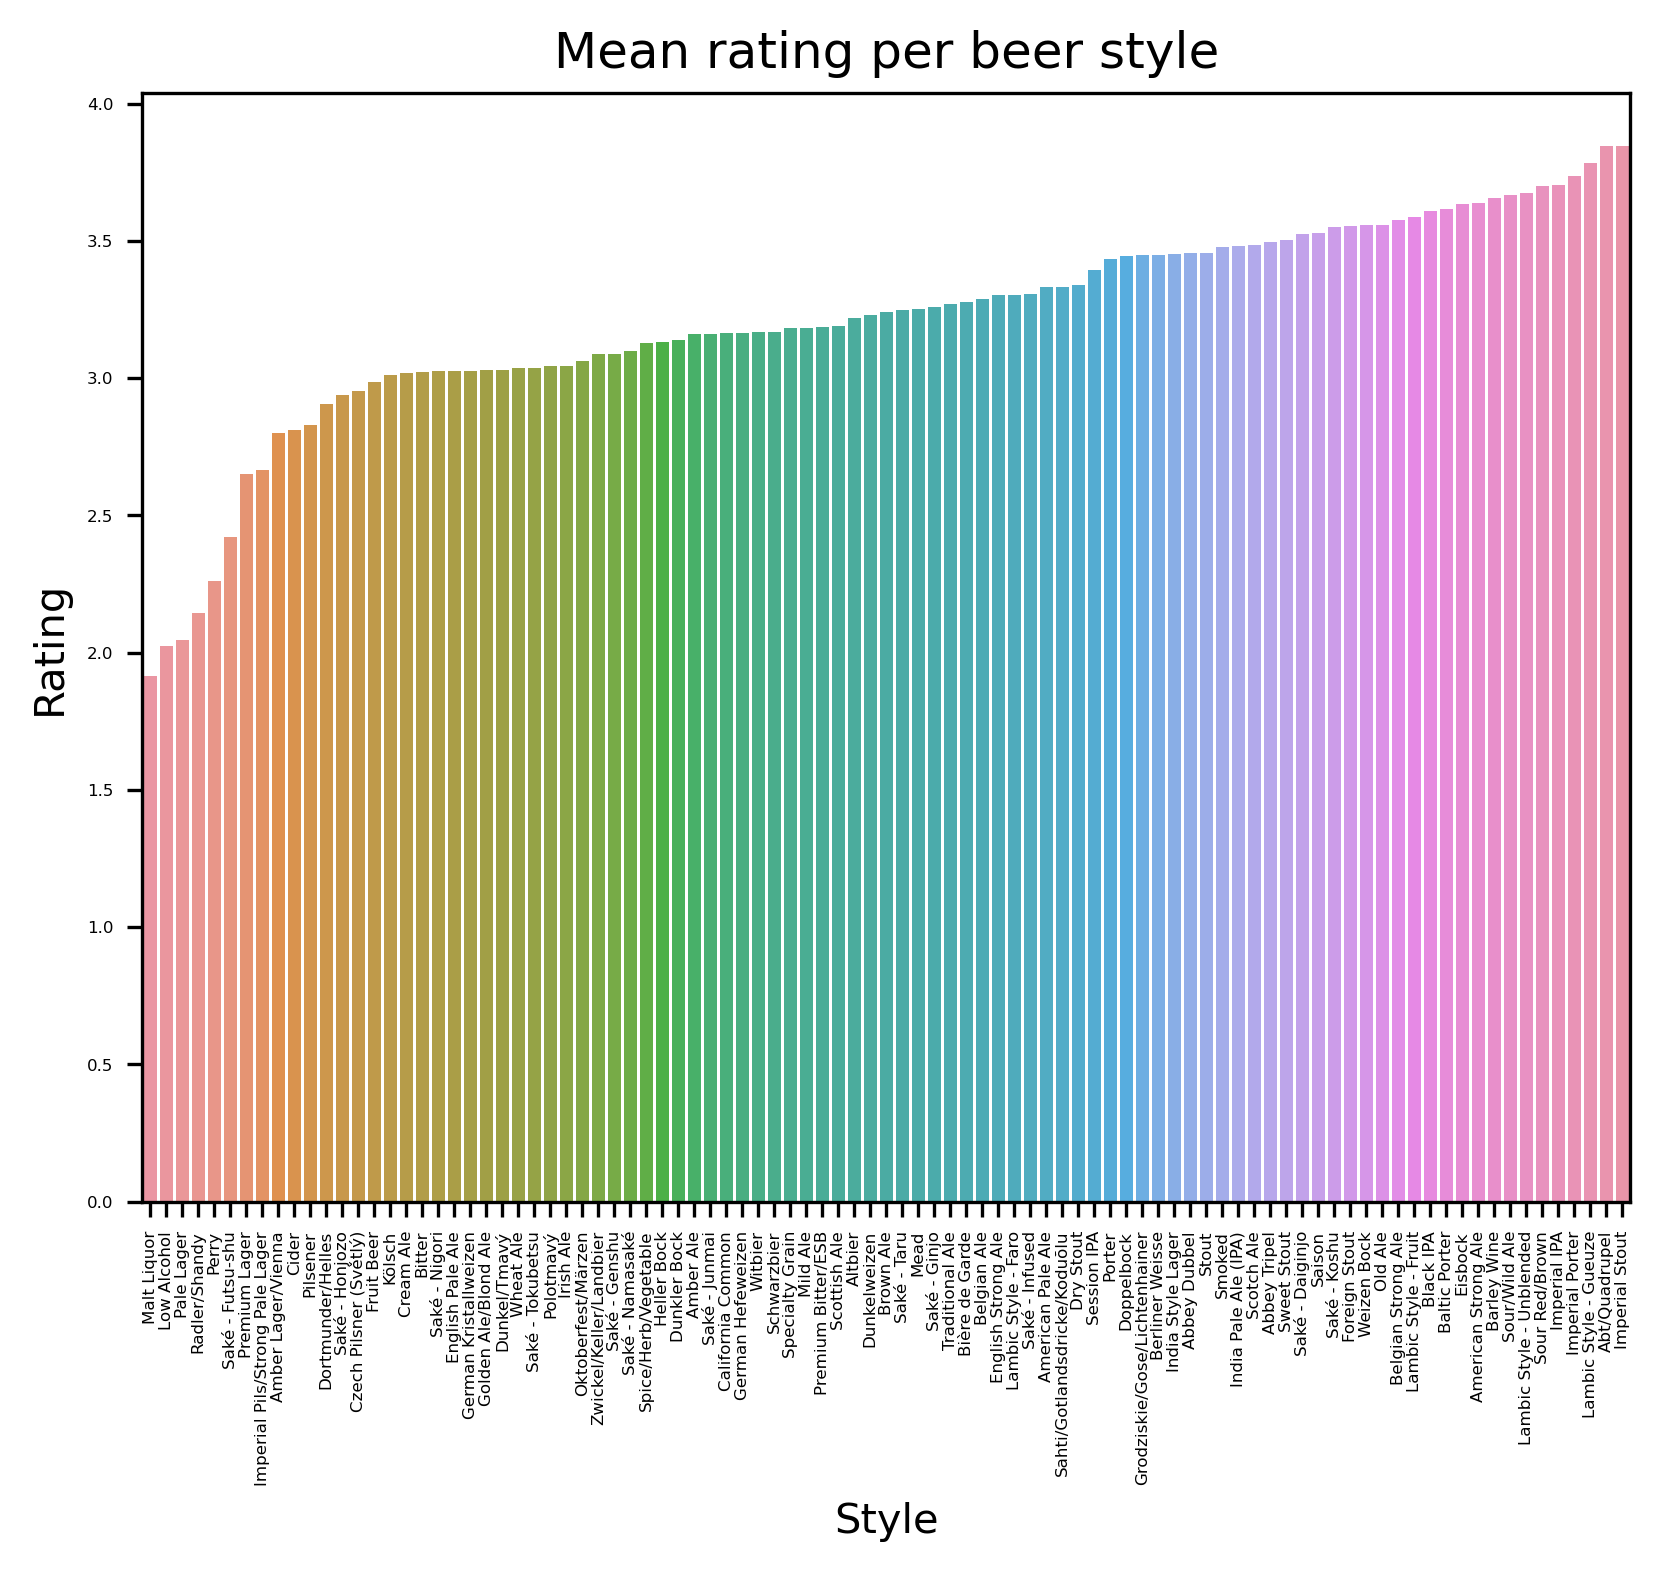

In [171]:
#[np.mean([df_interest_RB['rating'][df_interest_RB['category']==i]]) for i in categories]
mean_style = df_interest_RB.groupby('style')['rating'].mean()
df_mean_style = mean_style.to_frame()
df_mean_style = df_mean_style.sort_values(by=['rating'])

ax = sns.barplot(x = df_mean_style.index,y='rating', data=df_mean_style)
plt.title("Mean rating per beer style")
plt.xlabel("Style")
ax.tick_params(labelsize=4)
plt.xticks(rotation=90)
plt.ylabel("Rating")
plt.show()